<a href="https://colab.research.google.com/github/SahputraS/Outbreak-Simulation-and-Detection-Testing/blob/main/Outbreak_Detection_(Mosquito_Borne_Disease).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook aims to apply the outbreak detection to the mosquito-borne-disease  dataset from https://journals.plos.org/plosntds/article?id=10.1371/journal.pntd.0009259

In [ ]:
# Download the packages if not already available
packages_needed <- c("readxl","surveillance", "forecast", "stringi", "lubridate")
packages_to_install <- packages_needed[!(packages_needed %in% installed.packages()[,"Package"])]

if(length(packages_to_install)) {
  install.packages(packages_to_install)
}
lapply(packages_needed, library, character.only = TRUE)

[[1]]
 [1] "googledrive"  "ggplot2"      "dplyr"        "lubridate"    "stringi"     
 [6] "forecast"     "surveillance" "xtable"       "sp"           "readxl"      
[11] "stats"        "graphics"     "grDevices"    "utils"        "datasets"    
[16] "methods"      "base"        

[[2]]
 [1] "googledrive"  "ggplot2"      "dplyr"        "lubridate"    "stringi"     
 [6] "forecast"     "surveillance" "xtable"       "sp"           "readxl"      
[11] "stats"        "graphics"     "grDevices"    "utils"        "datasets"    
[16] "methods"      "base"        

[[3]]
 [1] "googledrive"  "ggplot2"      "dplyr"        "lubridate"    "stringi"     
 [6] "forecast"     "surveillance" "xtable"       "sp"           "readxl"      
[11] "stats"        "graphics"     "grDevices"    "utils"        "datasets"    
[16] "methods"      "base"        

[[4]]
 [1] "googledrive"  "ggplot2"      "dplyr"        "lubridate"    "stringi"     
 [6] "forecast"     "surveillance" "xtable"       "sp"           "readxl"      
[11] "stats"        "graphics"     "grDevices"    "utils"        "datasets"    
[16] "methods"      "base"        

[[5]]
 [1] "googledrive"  "ggplot2"      "dplyr"        "lubridate"    "stringi"     
 [6] "forecast"     "surveillance" "xtable"       "sp"           "readxl"      
[11] "stats"        "graphics"     "grDevices"    "utils"        "datasets"    
[16] "methods"      "base"

In [ ]:
library(readxl)
library(stringi)

library(surveillance)

library(dplyr)
library(ggplot2)

library(lubridate)

# Download Dataset

In [ ]:
url <- "https://journals.plos.org/plosntds/article/file?type=supplementary&id=info:doi/10.1371/journal.pntd.0009259.s001"
download.file(url, destfile = "data.xlsx", mode = "wb")

# Focusing on the first sheet where the data is
excel_sheets("data.xlsx")
data <- read_excel("data.xlsx", sheet = 1)
cat("The columns are:", paste(colnames(data), collapse = ", "), "\n")

# Since the interest is only on the mosquito borne diseases, I take only the first 8 columns
data <- data[1:8]

# Remove the spanish accent (Sorry, this is due to my US keyboard)
data$Municipality <- stri_trans_general(data$Municipality, "Latin-ASCII")

head(data)

[1] "Data"             "Variables Legend"

The columns are: Municipality, Year, Week, Chikungunya incidence, Dengue incidence, Severe dengue incidence, Zika incidence, Total arbovirus incidence, Tmax, Tmin, Tavg, Precipitation, Havg, Wsmax, Wsmin, WSavg, Elevation, Population, MPI, Illiteracy, Low Educational Achievement, School lag, School absence, Barriers to childhood services, Child labour, No health insurance, Barriers to health services, Informal work, Dependency rate, No access improved water, Inadequate excreta disposal, Inappropriate flooring material, Inappropriate wall exterior, Critical overcrowding 


Municipality,Year,Week,Chikungunya incidence,Dengue incidence,Severe dengue incidence,Zika incidence,Total arbovirus incidence
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Bello,2007,1,0,0,0,0,0
Bello,2007,2,0,0,0,0,0
Bello,2007,3,0,0,0,0,0
Bello,2007,4,0,0,0,0,0
Bello,2007,5,0,0,0,0,0
Bello,2007,6,0,0,0,0,0


In [ ]:
mun = unique(data$Municipality)
cat("The municipalities in the dataset are:",paste(mun, collapse = ", "))

The municipalities in the dataset are: Bello, Cucuta, Moniquira

In [ ]:
data_mun <- split(data, data$Municipality)

# Data Visualization

In [ ]:
illness <- c("Chikungunya incidence", "Dengue incidence", "Severe dengue incidence", "Zika incidence")

In [ ]:
plot_incidence <- function(df_list, illness, plot_title = NULL) {

  # Combine all municipalities into one dataframe
  plot_df <- bind_rows(
    lapply(names(df_list), function(mun) {
      df <- df_list[[mun]]
      df$Municipality <- mun
      df
    })
  )

  # Make the year and week information into a proper date format
  plot_df <- plot_df %>%
    mutate(Date = as.Date(paste(Year, Week, 1, sep = "-"), format = "%Y-%U-%u"))

  illness_sym <- rlang::sym(illness)
  plot_title <- illness

  options(repr.plot.width = 20, repr.plot.height = 8)
  ggplot(plot_df, aes(x = Date, y = !!illness_sym, color = Municipality)) +
    geom_line(size = 1) +
    labs(
      title = plot_title,
      x = "Year-Week",
      y = "Incidence"
    ) +
    theme_minimal(base_size = 20) +
    theme(
      axis.text.x = element_text(angle = 0, hjust = 1)
    )
}

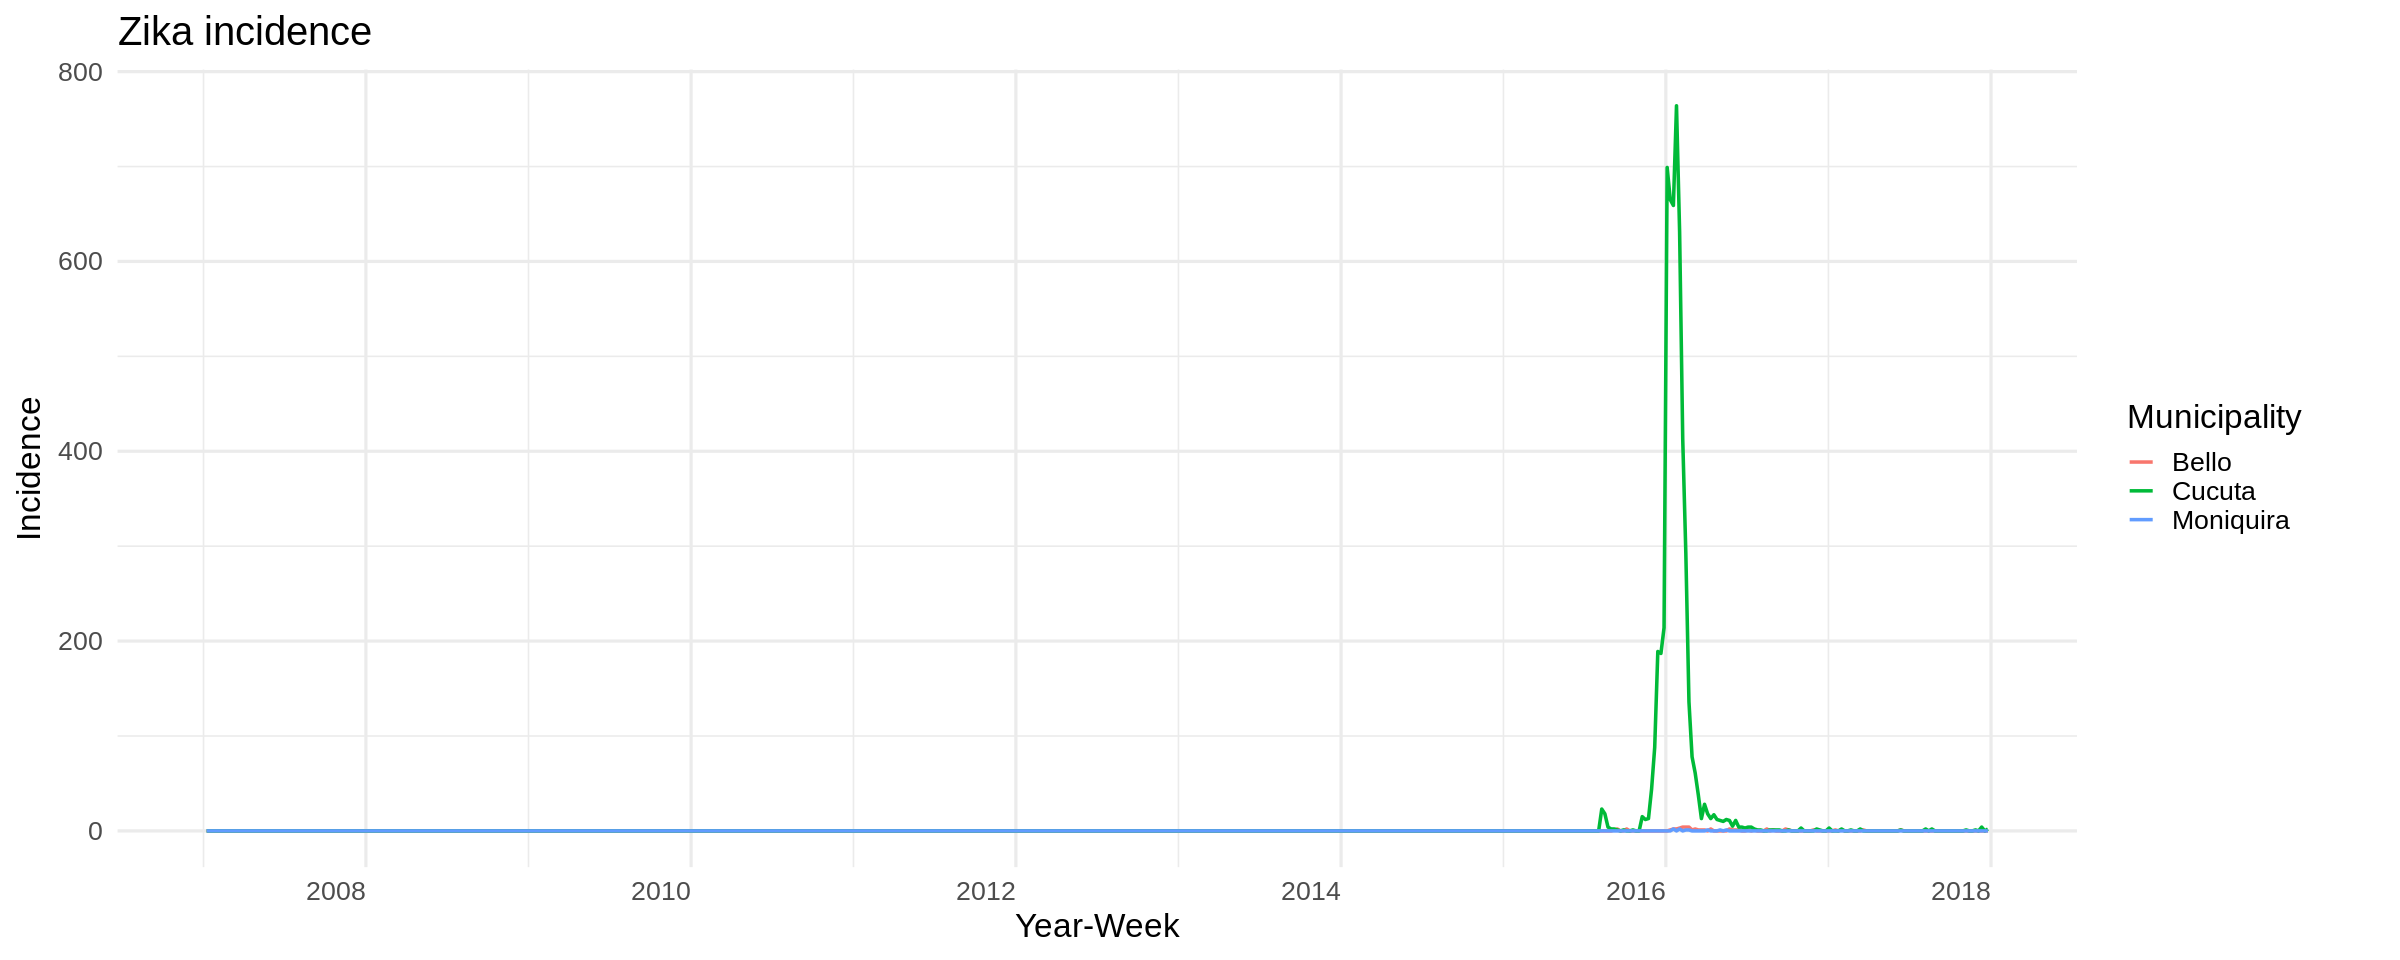

In [ ]:
plot_incidence(data_mun, "Zika incidence")

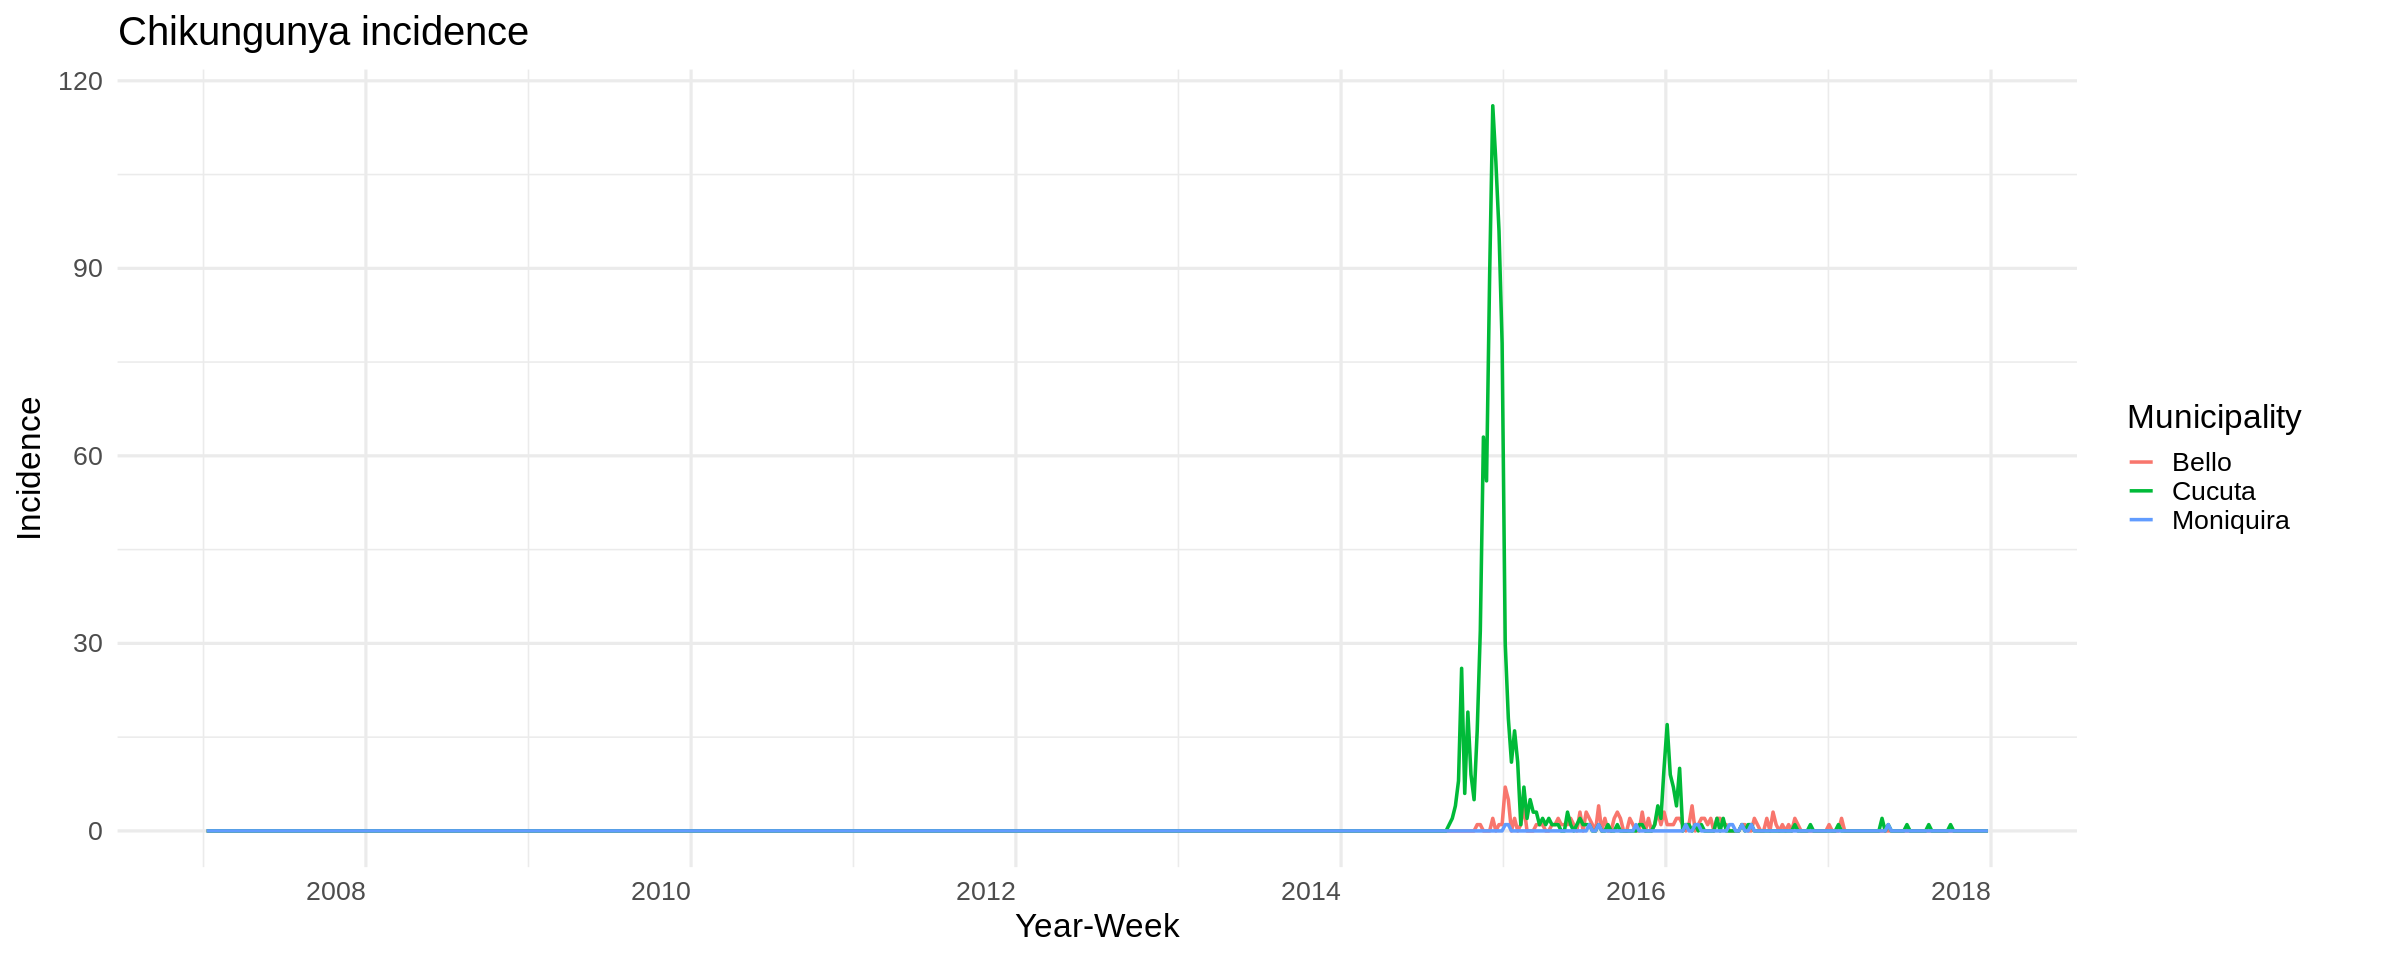

In [ ]:
plot_incidence(data_mun, "Chikungunya incidence")

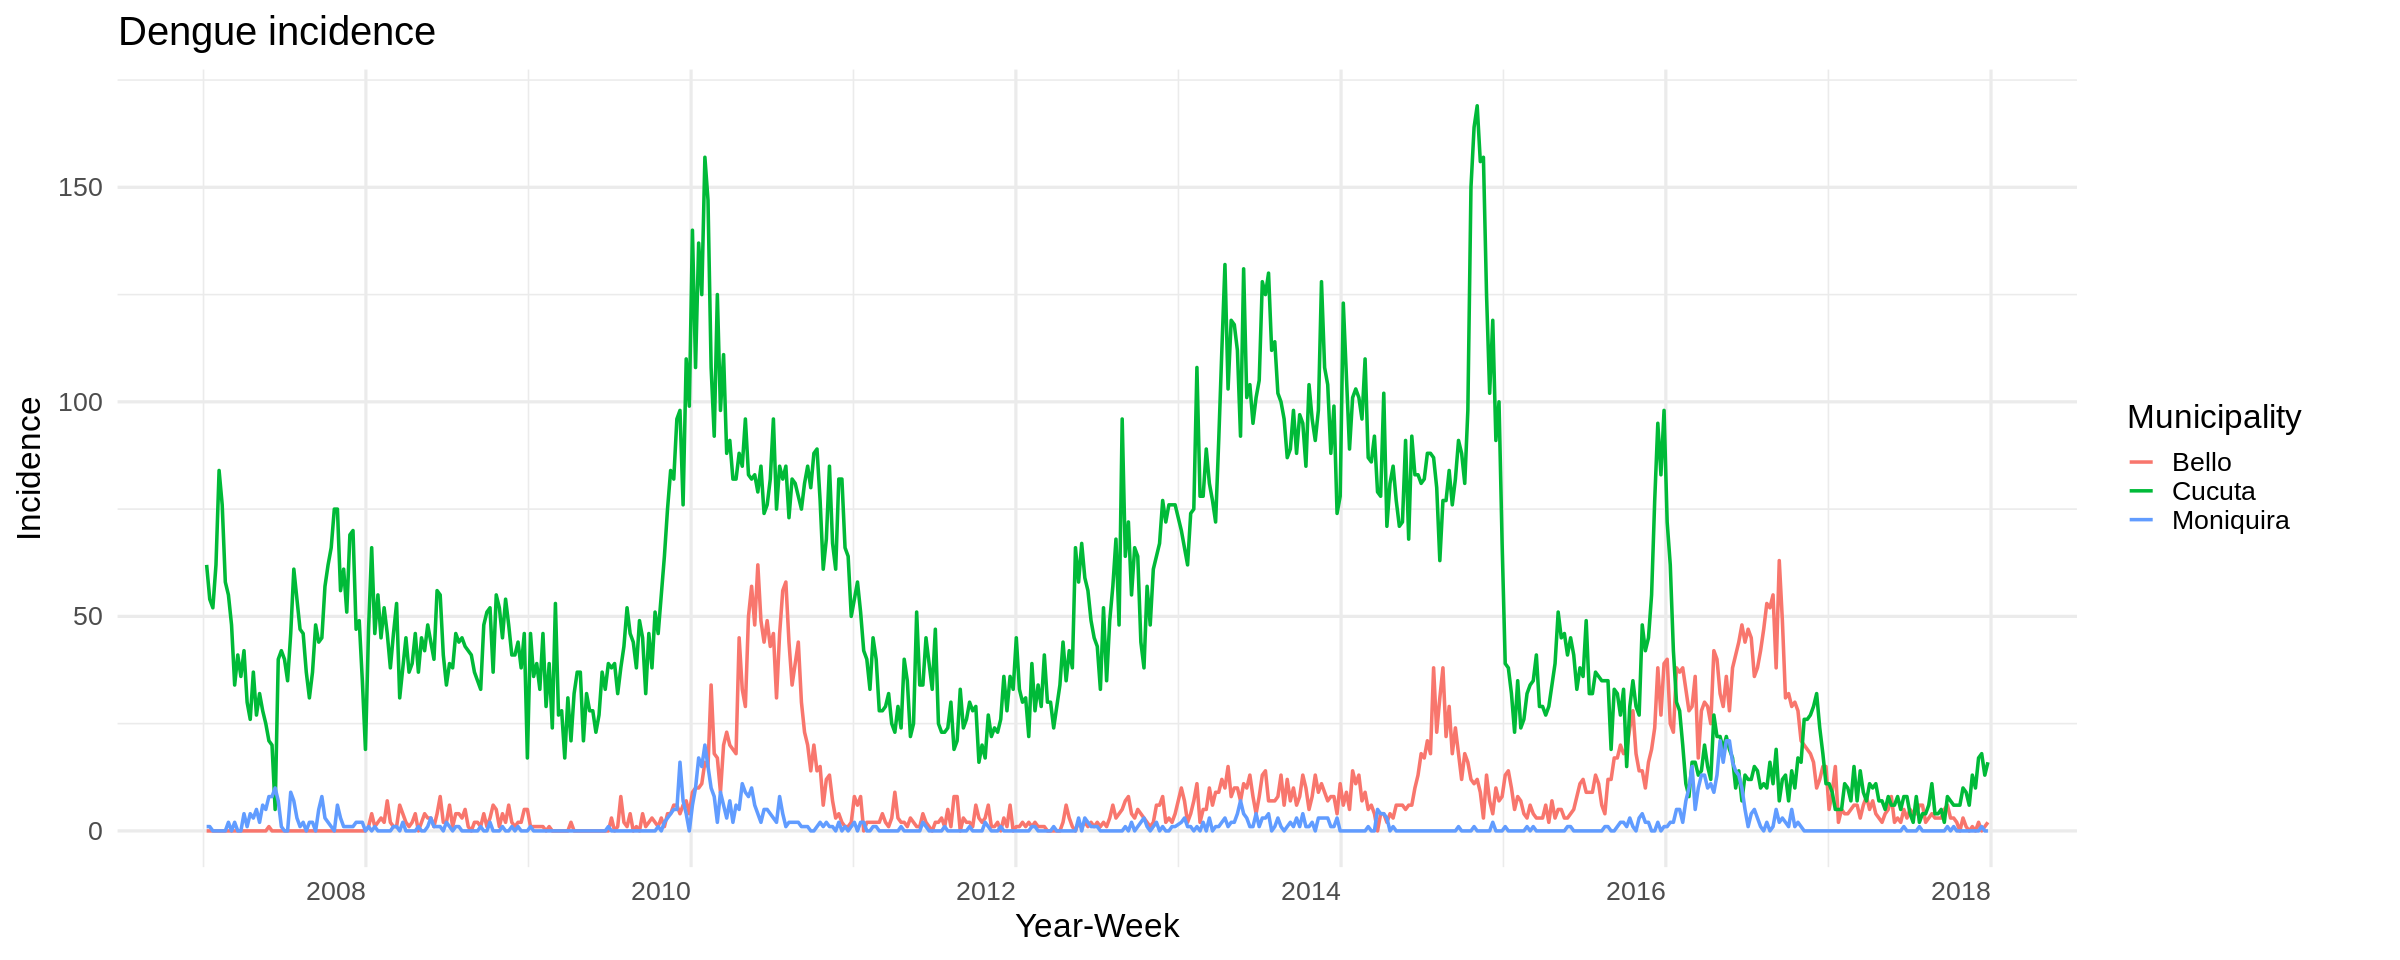

In [ ]:
plot_incidence(data_mun, "Dengue incidence")

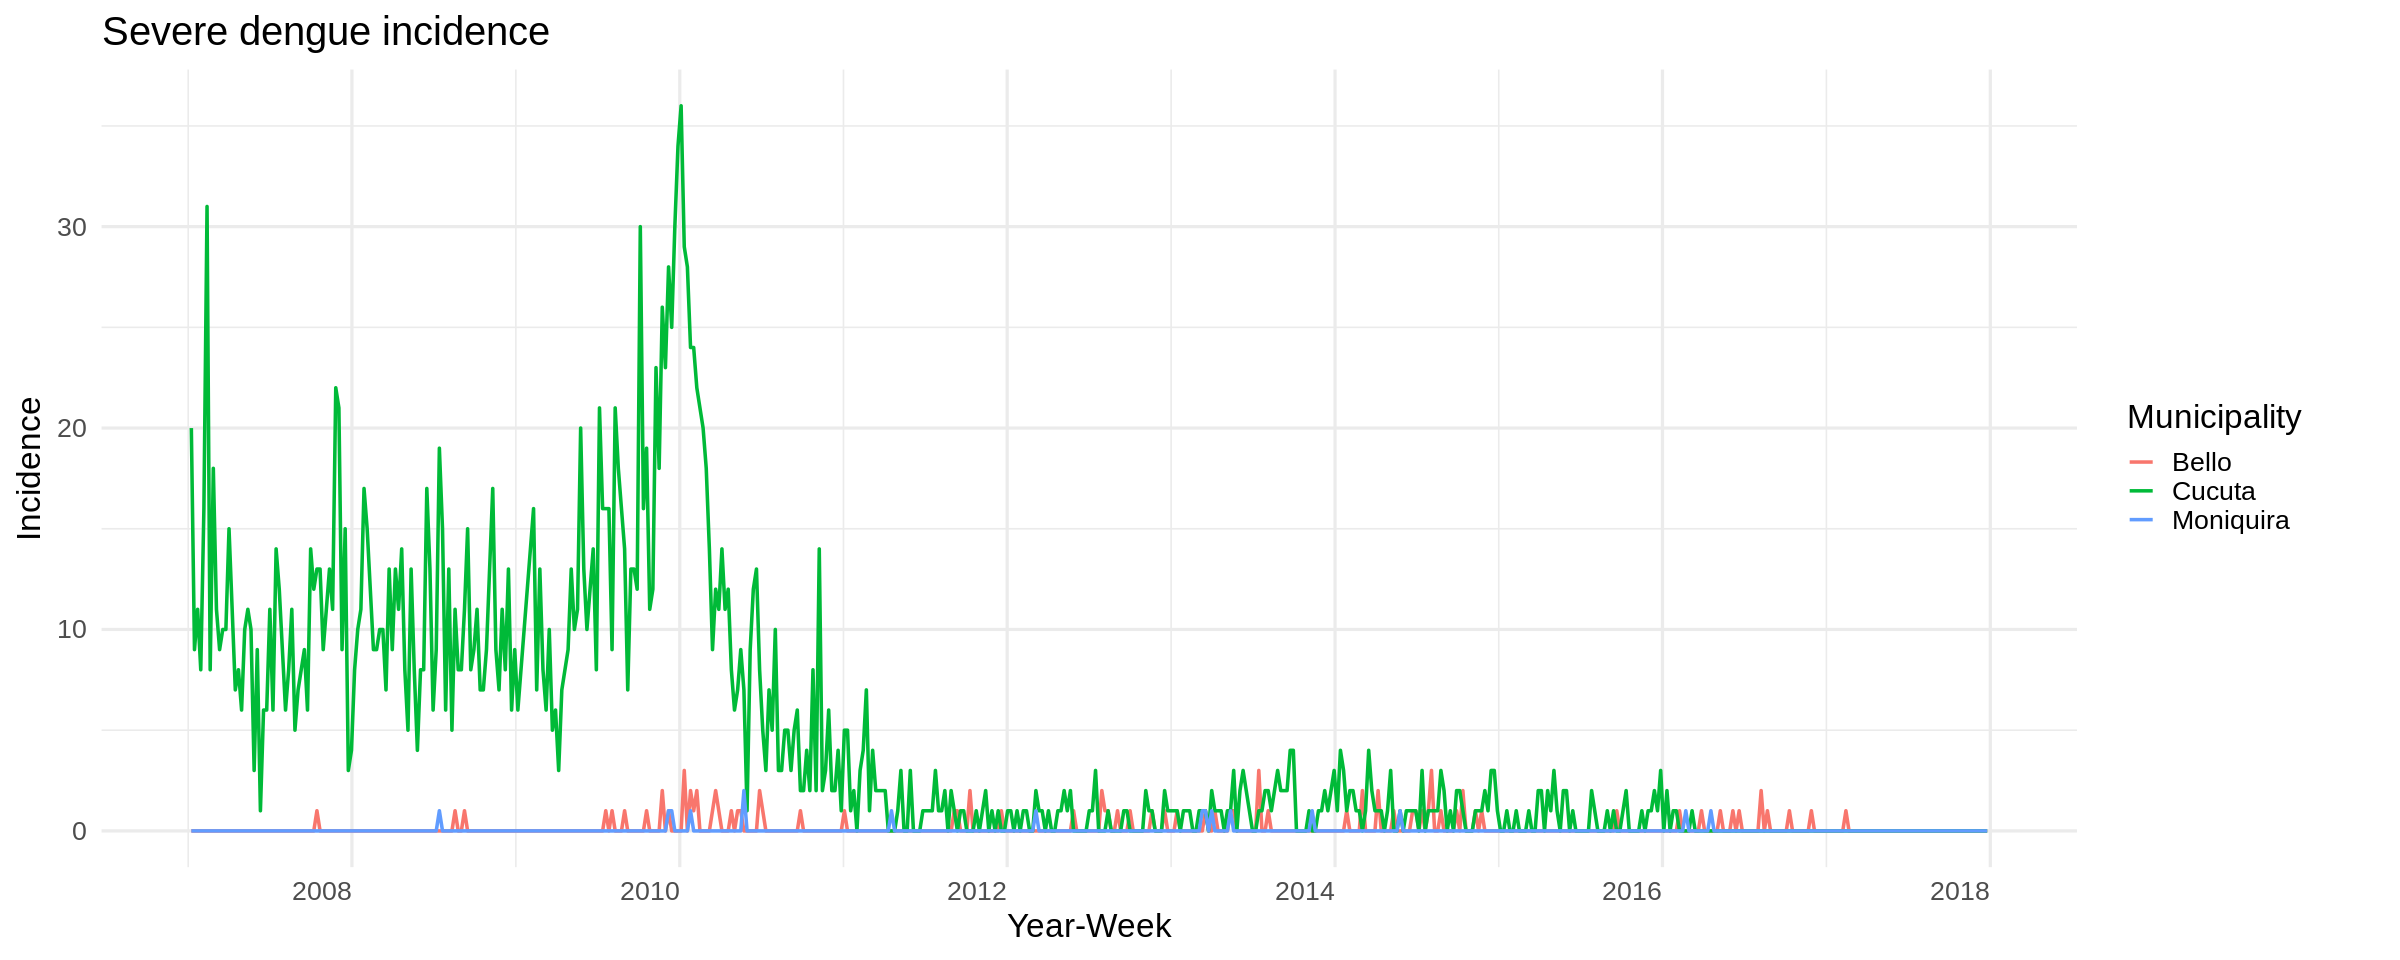

In [ ]:
plot_incidence(data_mun, "Severe dengue incidence")

- After looking at the data, I'd focus on the Dengue for now
- I am not so sure if I should combine Dengue and Severe Dengue or not. I think it is not a problem to combine them especially since the severe dengue incidence is not a subset of dengue incidence, therefore combining the two would not results in double-counting.
- I also think I might need to combine the 3 locations into 1 global "Colombia" or at least combine Bello and Moniquira (so i can keep the Multiple region situation) because the Flex-Farrington algorithm doesn't work if there is too long period with 0 values (sparse data)

In [ ]:
# Combine dengue and severe dengue incidence
dd <- data %>%
  mutate(Dengue_total = `Dengue incidence` + `Severe dengue incidence`) %>%
  select(Municipality, Year, Week, Dengue_total)

# rewrite the data by municipality since the focus is now only on the dengue
data_by_mun <- split(dd, data$Municipality)
cucuta_dengue <- data_by_mun$Cucuta

In [ ]:
# Combine the two municipalities by summing Dengue_total by Year and Week
bello_moniquira <- dd %>%
  filter(Municipality %in% c("Bello", "Moniquira")) %>%
  group_by(Year, Week) %>%
  summarize(Dengue_total = sum(Dengue_total, na.rm = TRUE)) %>%
  ungroup() %>%
  mutate(Municipality = "Bello+Moniquira")

bemon_dengue <- bello_moniquira %>% arrange(Year, Week)

`summarise()` has grouped output by 'Year'. You can override using the
`.groups` argument.


In [ ]:
cols <- c("Municipality", "Year", "Week", "Dengue_total")
cucuta_dengue <- cucuta_dengue[, cols]
bemon_dengue <- bemon_dengue[, cols]

In [ ]:
head(bemon_dengue,2)

Municipality,Year,Week,Dengue_total
<chr>,<dbl>,<dbl>,<dbl>
Bello+Moniquira,2007,1,1
Bello+Moniquira,2007,2,1


In [ ]:
head(cucuta_dengue,2)

Municipality,Year,Week,Dengue_total
<chr>,<dbl>,<dbl>,<dbl>
Cucuta,2007,1,82
Cucuta,2007,2,63


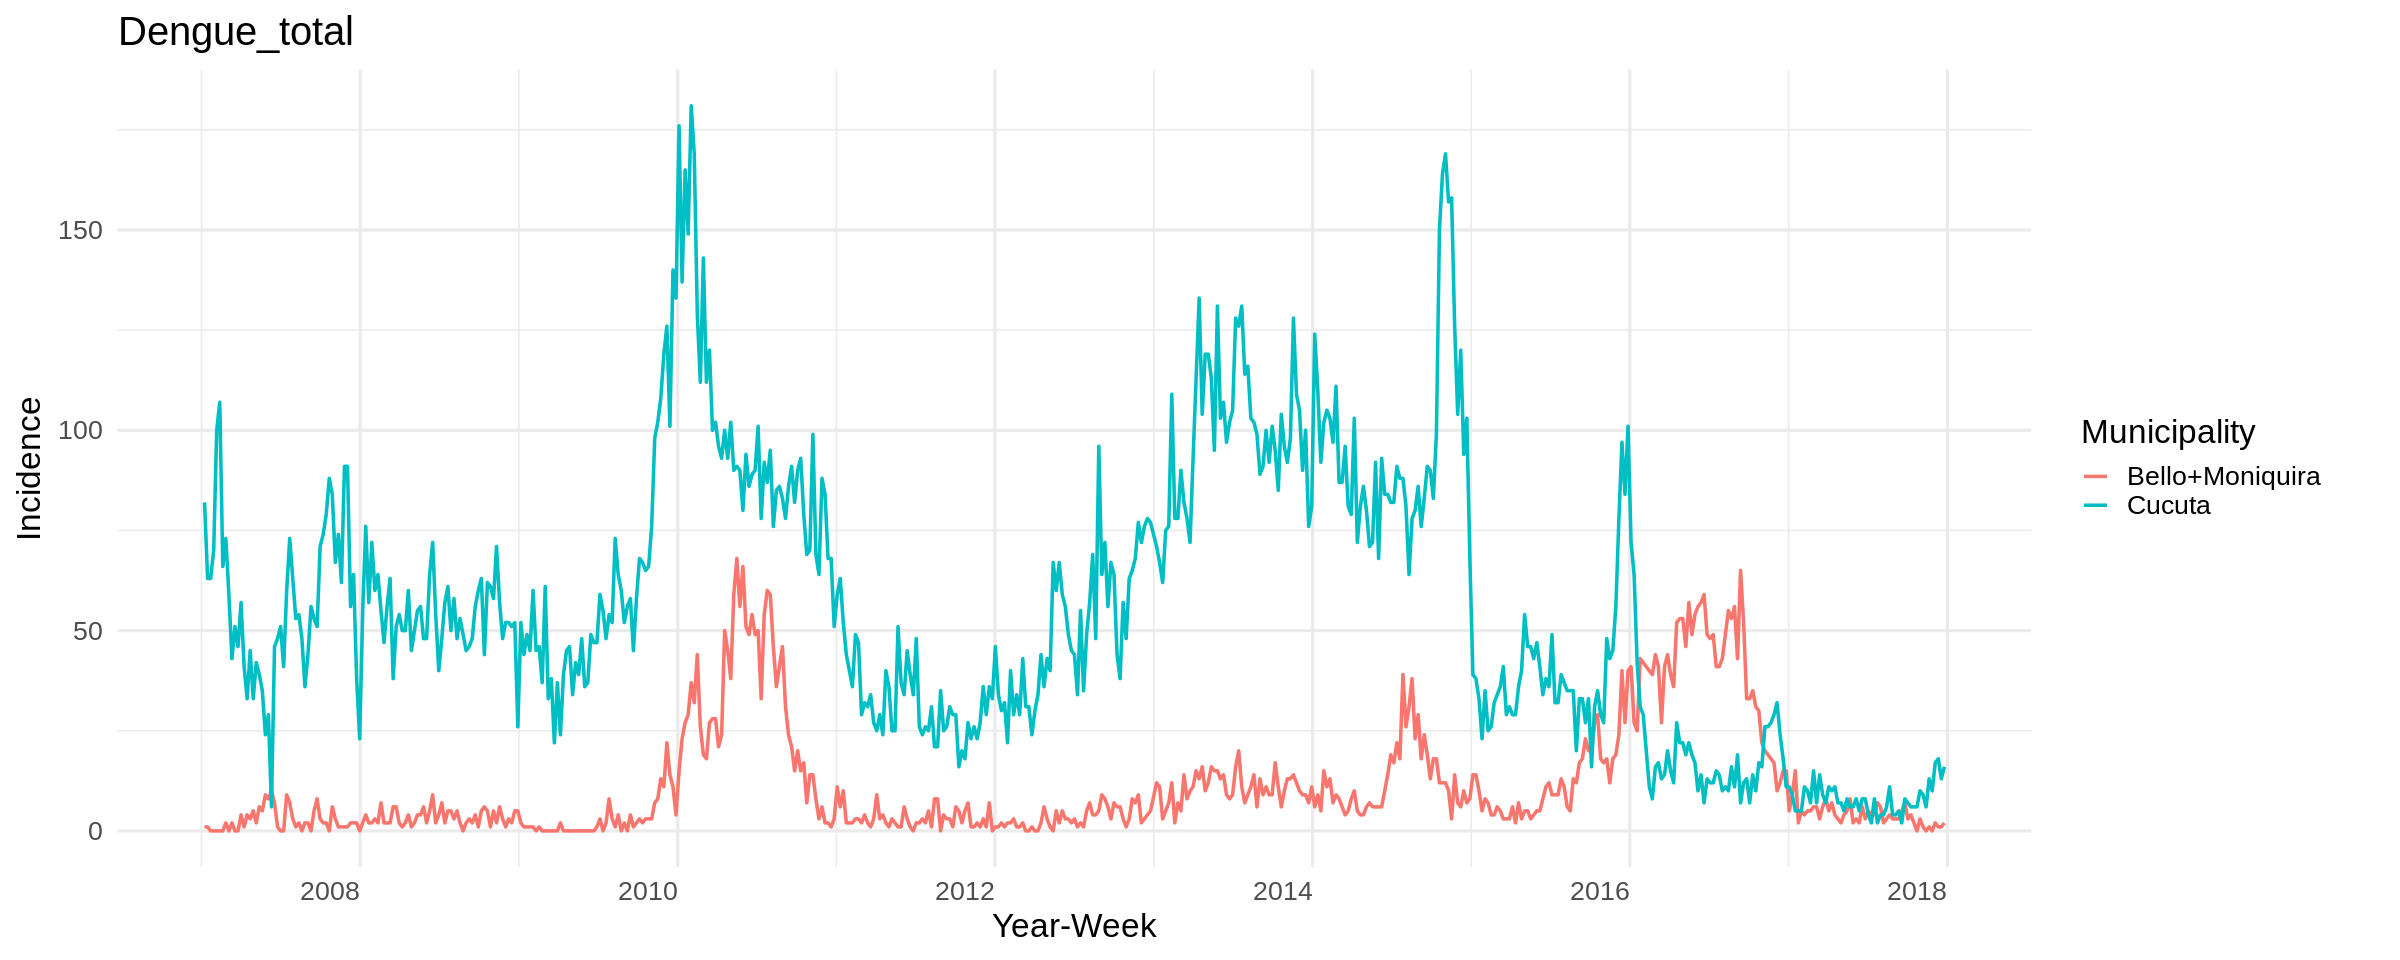

In [ ]:
dengue_mun <- list(
  "Cucuta" = cucuta_dengue,
  "Bello+Moniquira" = bemon_dengue
)
plot_incidence(dengue_mun, "Dengue_total", plot_title = 'Total Dengue Incidence')

# **Detection Functions (Farrington Flexible, EARS, ARIMA)**

In [ ]:
detect_farrington_flex <- function(df, b = 1, w = 1, noPeriods = 1, pastWeeksNotIncluded = 0, trend = FALSE) {

  # Create the sts object
  sts_week <- sts(observed = df$Reported_Cases, freq = 1)

  # Run Farrington Flexible
  farr_week <- farringtonFlexible(
    sts_week,
    control = list(
      b = b, w = w, noPeriods = noPeriods,
      pastWeeksNotIncluded = pastWeeksNotIncluded,
      trend = trend,
      alpha = 0.05
    )
  )

  # Just taking the variable to match the week with the alarm
  n_result <- length(observed(farr_week))
  max_week <- max(df$Week)

  # Store the "forecast" values
  forecast_df <- tibble::tibble(
    target_week = (max_week - n_result + 1):max_week,
    actual_value = observed(farr_week),
    upper_bound = upperbound(farr_week),
    Alarm = as.numeric(alarms(farr_week) > 0)
  )

  return(list(signal = forecast_df$Alarm, forecast = forecast_df))
}


In [ ]:
# EARS detection
detect_ears <- function(df, method = "C3", baseline = 100) {
  # Convert to sts object
  sts_cases <- sts(observed = df$Reported_Cases, freq = 1)
  # EARS with the method can be C1/C2/C3 and baseline is the temporal window
  ears <- earsC(sts_cases, control = list(method = method, baseline = baseline))

  # Just taking the variable to match the week with the alarm
  n_result <- length(observed(ears))
  max_week <- max(df$Week)

  # Store the "forecast" values
  forecast_df <- tibble::tibble(
    target_week = (max_week - n_result + 1):max_week,
    actual_value = observed(ears),
    upper_bound = upperbound(ears),
    Alarm = as.numeric(alarms(ears) > 0)
  )

  return(list(signal = forecast_df$Alarm, forecast = forecast_df))
}

In [ ]:
# ARIMA detection
detect_arima <- function(df, window_size = 100, interval = 0.95, jump = 1) {
  # Parameters:
  # df = input data
  # window_size = initial training size (burn-in)
  # interval = confidence level for prediction interval (e.g., 0.95)
  # jump = number of days to move the forecast window forward

  n <- nrow(df)  # Total number of timepoints
  arima_signal <- rep(0, n)  # Initialize outbreak signal (0 = no alarm)
  forecast_records <- list()  # List to store forecast info

  t <- window_size + 1  # Start detection after initial training window

  while (t <= n) {
    start_day <- 1  # Expanding window always starts from day 1
    train_data <- df$Reported_Cases[start_day:(t - 1)] # Train data since day one untill yesterday/last week to get the predicted now

    # Fit ARIMA model on training data
    arima_fit <- auto.arima(train_data)

    # Forecast next few days (up to jump days or until end)
    h <- min(jump, n - t + 1)
    preds <- forecast(arima_fit, h = h, level = interval * 100)

    # Extract upper bounds and means
    uppers <- preds$upper[, 1]
    lowers <- preds$lower[, 1]
    means <- preds$mean

    # Loop through forecast horizon
    for (j in 0:(h - 1)) {
      tt <- t + j  # Actual index in data
      if (tt > n) break

      actual_value <- df$Reported_Cases[tt]

      # I want to safe the forecast results
      forecast_records[[length(forecast_records) + 1]] <-  tibble::tibble(
        forecast_week = df$Week[t],
        target_week = df$Week[tt],
        forecast_mean = means[j + 1],
        upper_bound = uppers[j + 1],
        lower_bound = lowers[j + 1],
        # These two information below is just for cross-checking with the original data
        actual_value = actual_value,
      )

      # Raise alarm if actual value exceeds prediction upper bound
      if (actual_value > uppers[j + 1]) {
        arima_signal[tt] <- 1
      }
    }

    t <- t + jump  # Move the forecasting step forward
  }

  # Construct forecast data frame and trim signal to post-burn-in
  forecast_df <- do.call(rbind, forecast_records)
  arima_signal_trimmed <- arima_signal[(window_size + 1):n]

  return(list(
    signal = arima_signal_trimmed,
    forecast_df = forecast_df
  ))
}

# **Run The Analysis**

Note: The analysis is currently running slow. I might need to revisit the algorithm and do some optimization.

In [ ]:
analyze_region <- function(df, detectors, region_id = NULL) {
  # Run all detectors, collect outputs
  detector_outputs <- lapply(detectors, function(f) f(df))

  # Get signals
  signals_list <- lapply(detector_outputs, function(x) x$signal)
  names(signals_list) <- names(detectors)

  # Find minimum length (align different detector signal lengths)
  all_lengths <- sapply(signals_list, length)
  min_len <- min(all_lengths)

  # and trim signals
  signals_cut <- lapply(signals_list, tail, min_len)

  # Also get forecasts if available
  forecast_list <- lapply(detector_outputs, function(x) tail(x$forecast, min_len))
  names(forecast_list) <- names(detectors)


  signals_df <- data.frame(
    Week = tail(df$Week, min_len),
    signals_cut
  )

  return(list(signals = signals_df, forecasts = forecast_list))
}

In [ ]:
detectors <- list(
  Farrington_Flexible = detect_farrington_flex,
  EARS = detect_ears,
  ARIMA = detect_arima
)

### Cucuta Outbreak Detection

In [ ]:
# Do some column renaming to fit the established framework (perhaps to be made more general later)
cucuta_dengue <- cucuta_dengue %>% rename(Reported_Cases = Dengue_total)
cucuta_dengue <- cucuta_dengue %>%
  rename(Week_inY = Week) %>%         # Rename 'Week' to 'Week_inY'
  mutate(Week = row_number())         # Do an indexing from 1 to N and named it as 'Week'

global_result_cucuta <- analyze_region(cucuta_dengue, detectors)

### Bello + Moniquira Outbreak Detection

In [ ]:
# Do some column renaming to fit the established framework (perhaps to be made more general later)
bemon_dengue <- bemon_dengue %>% rename(Reported_Cases = Dengue_total)
bemon_dengue <- bemon_dengue %>%
  rename(Week_inY = Week) %>%         # Rename 'Week' to 'Week_inY'
  mutate(Week = row_number())         # Do an indexing from 1 to N and named it as 'Week'

global_result_bemon <- analyze_region(bemon_dengue, detectors)

### Detection Visualization

In [ ]:
plot_detector_forecast <- function(result, detector_name = "ARIMA", place) {
  forecast_df <- result$forecasts[[detector_name]]

  # Band aid method because the output from different detection methods are not the same (to be fixed)
  # If Alarm column in forecast tibble doesn't exist, join it from the signals data
  if (!"Alarm" %in% names(forecast_df)) {
    signal_df <- result$signals %>%
      select(Week, Alarm = all_of(detector_name))
    forecast_df <- forecast_df %>%
      left_join(signal_df, by = c("target_week" = "Week"))
  }

  options(repr.plot.width = 20, repr.plot.height = 8)
  p <- ggplot(forecast_df, aes(x = target_week))

  # If there is a column named "lower bound", then make a prediction range plot (ribbon)
  if ("lower_bound" %in% names(forecast_df) && "upper_bound" %in% names(forecast_df)) {
    p <- p + geom_ribbon(aes(ymin = lower_bound, ymax = upper_bound, fill = "Prediction Interval"), alpha = 1)
  } else if ("upper_bound" %in% names(forecast_df)) { # If no "lower bound", then just plot upper bound (threshold)
    p <- p + geom_line(aes(y = upper_bound, color = "Upper Bound (Threshold)"), size = 1, linetype = "dashed")
  }

  # Plot reported cases
  p <- p +
    geom_line(aes(y = actual_value, color = "Actual"), size = 1)

  # Alarms as dot
  p <- p + geom_point(data = filter(forecast_df, Alarm == 1),
                      aes(y = actual_value, color = "Alarm"), size = 2.5)

  p <- p +
    scale_color_manual(name = "Legend",
                       values = c("Actual" = "black", "Alarm" = "red", "Upper Bound (Threshold)" = "blue")) +
    scale_fill_manual(name = "Legend", values = c("Prediction Interval" = "lightblue")) +
    labs(title = paste("Weekly Outbreak Detection with", detector_name, "in", place),
         x = "Week", y = "Weekly Incidence") +
    theme_minimal(base_size = 20) +
    theme(legend.position = "top")

  return(p)
}

### Plot Outbreak Cucuta

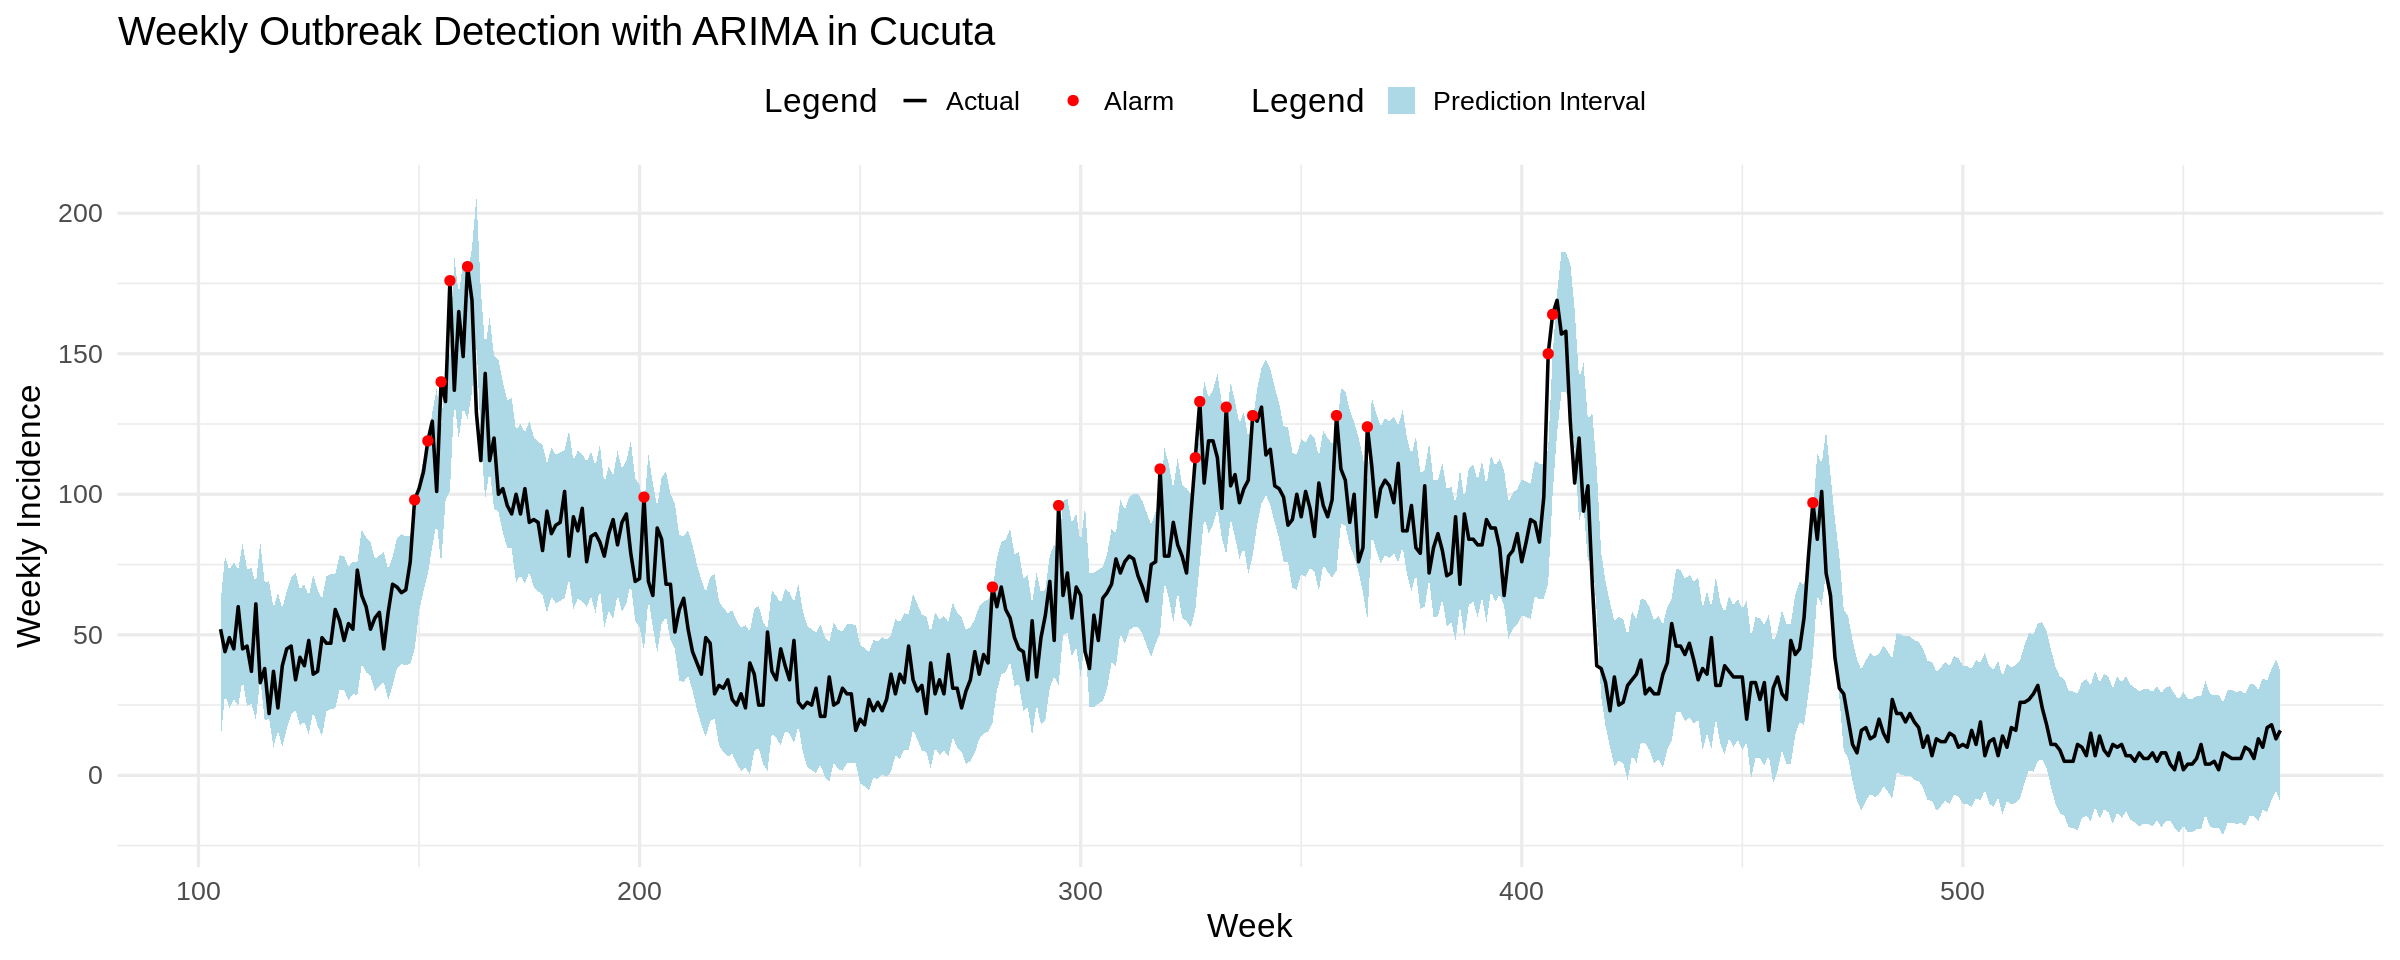

In [ ]:
plot_detector_forecast(global_result_cucuta, "ARIMA", "Cucuta")

Warning message:
“No shared levels found between `names(values)` of the manual scale and the
data's fill values.”


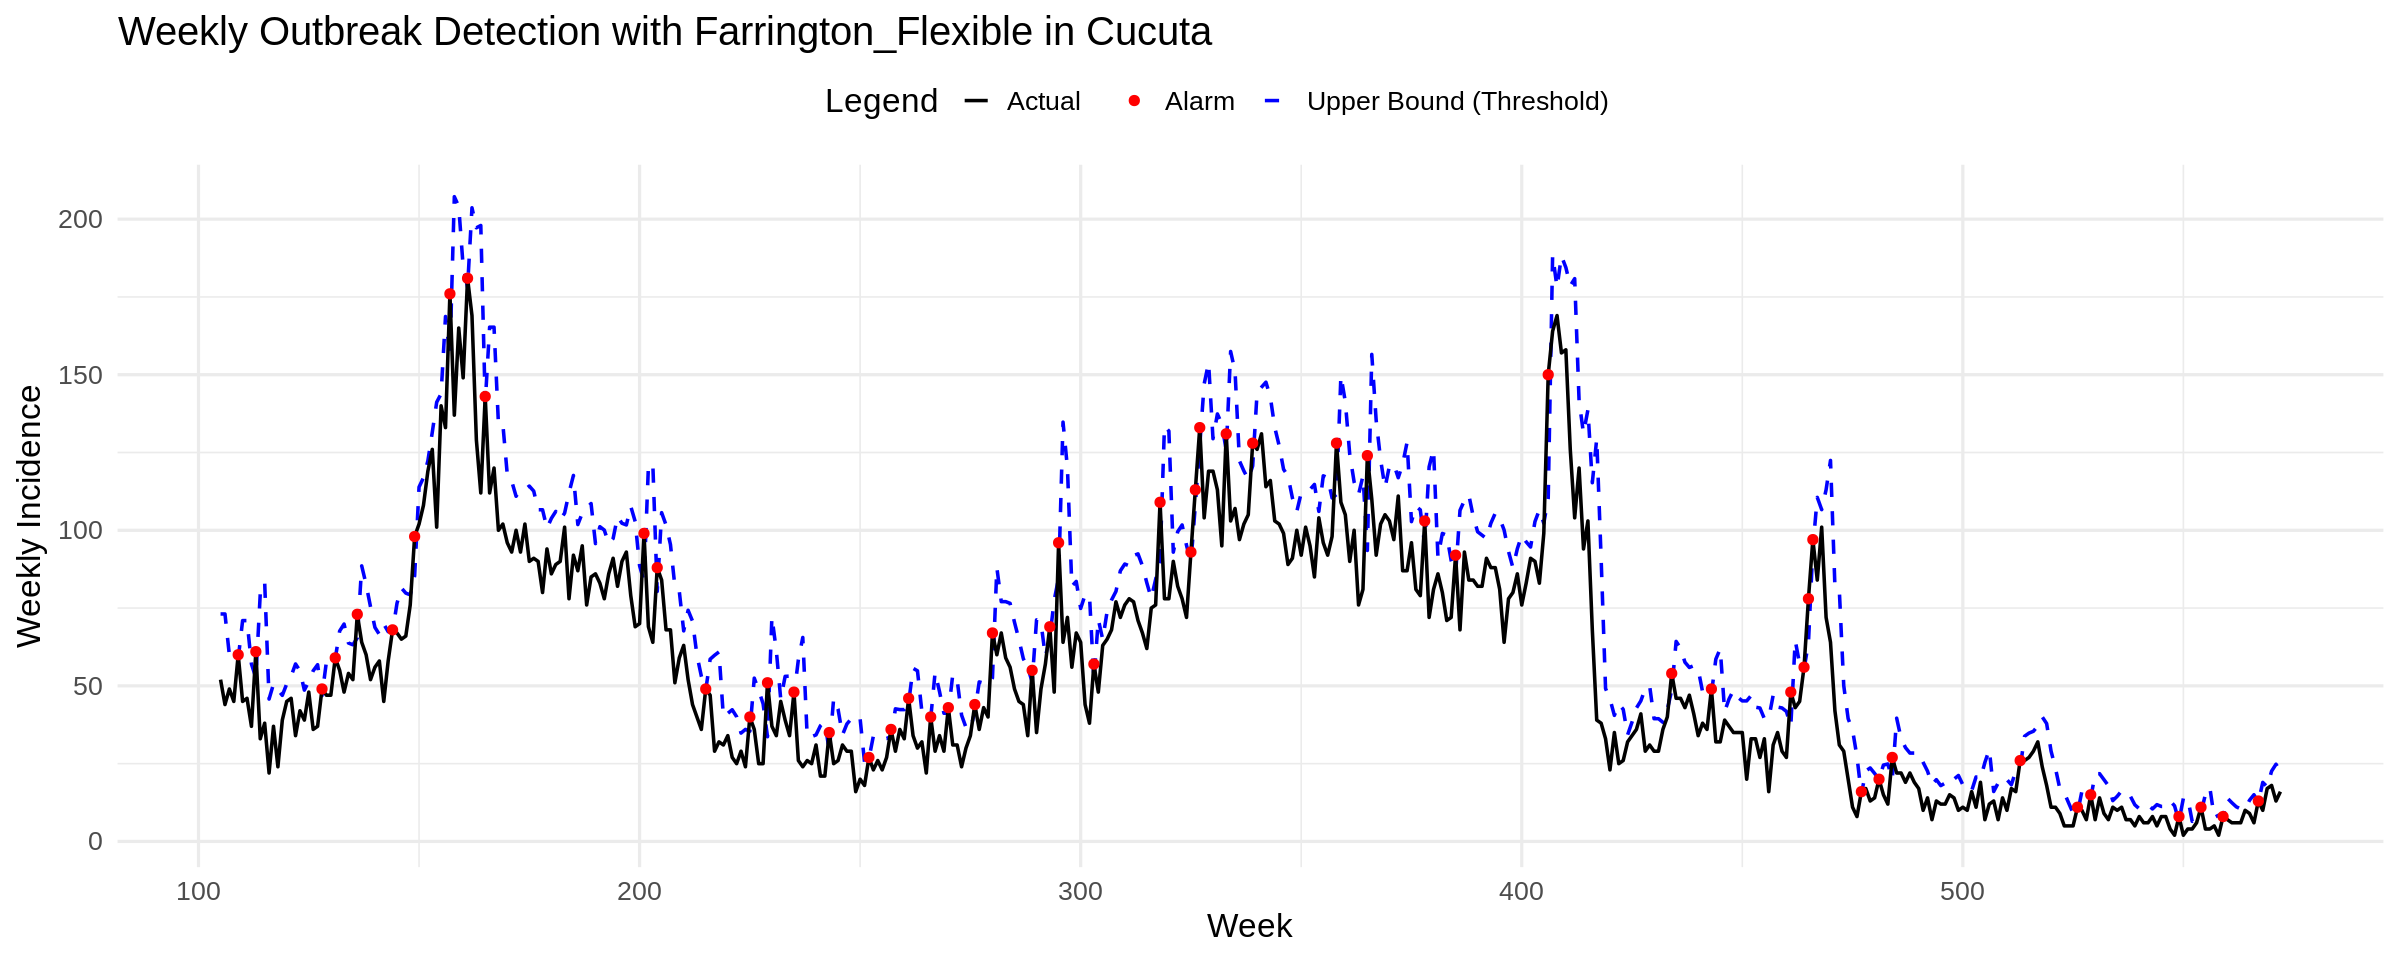

In [ ]:
plot_detector_forecast(global_result_cucuta, "Farrington_Flexible", "Cucuta")

Warning message:
“No shared levels found between `names(values)` of the manual scale and the
data's fill values.”


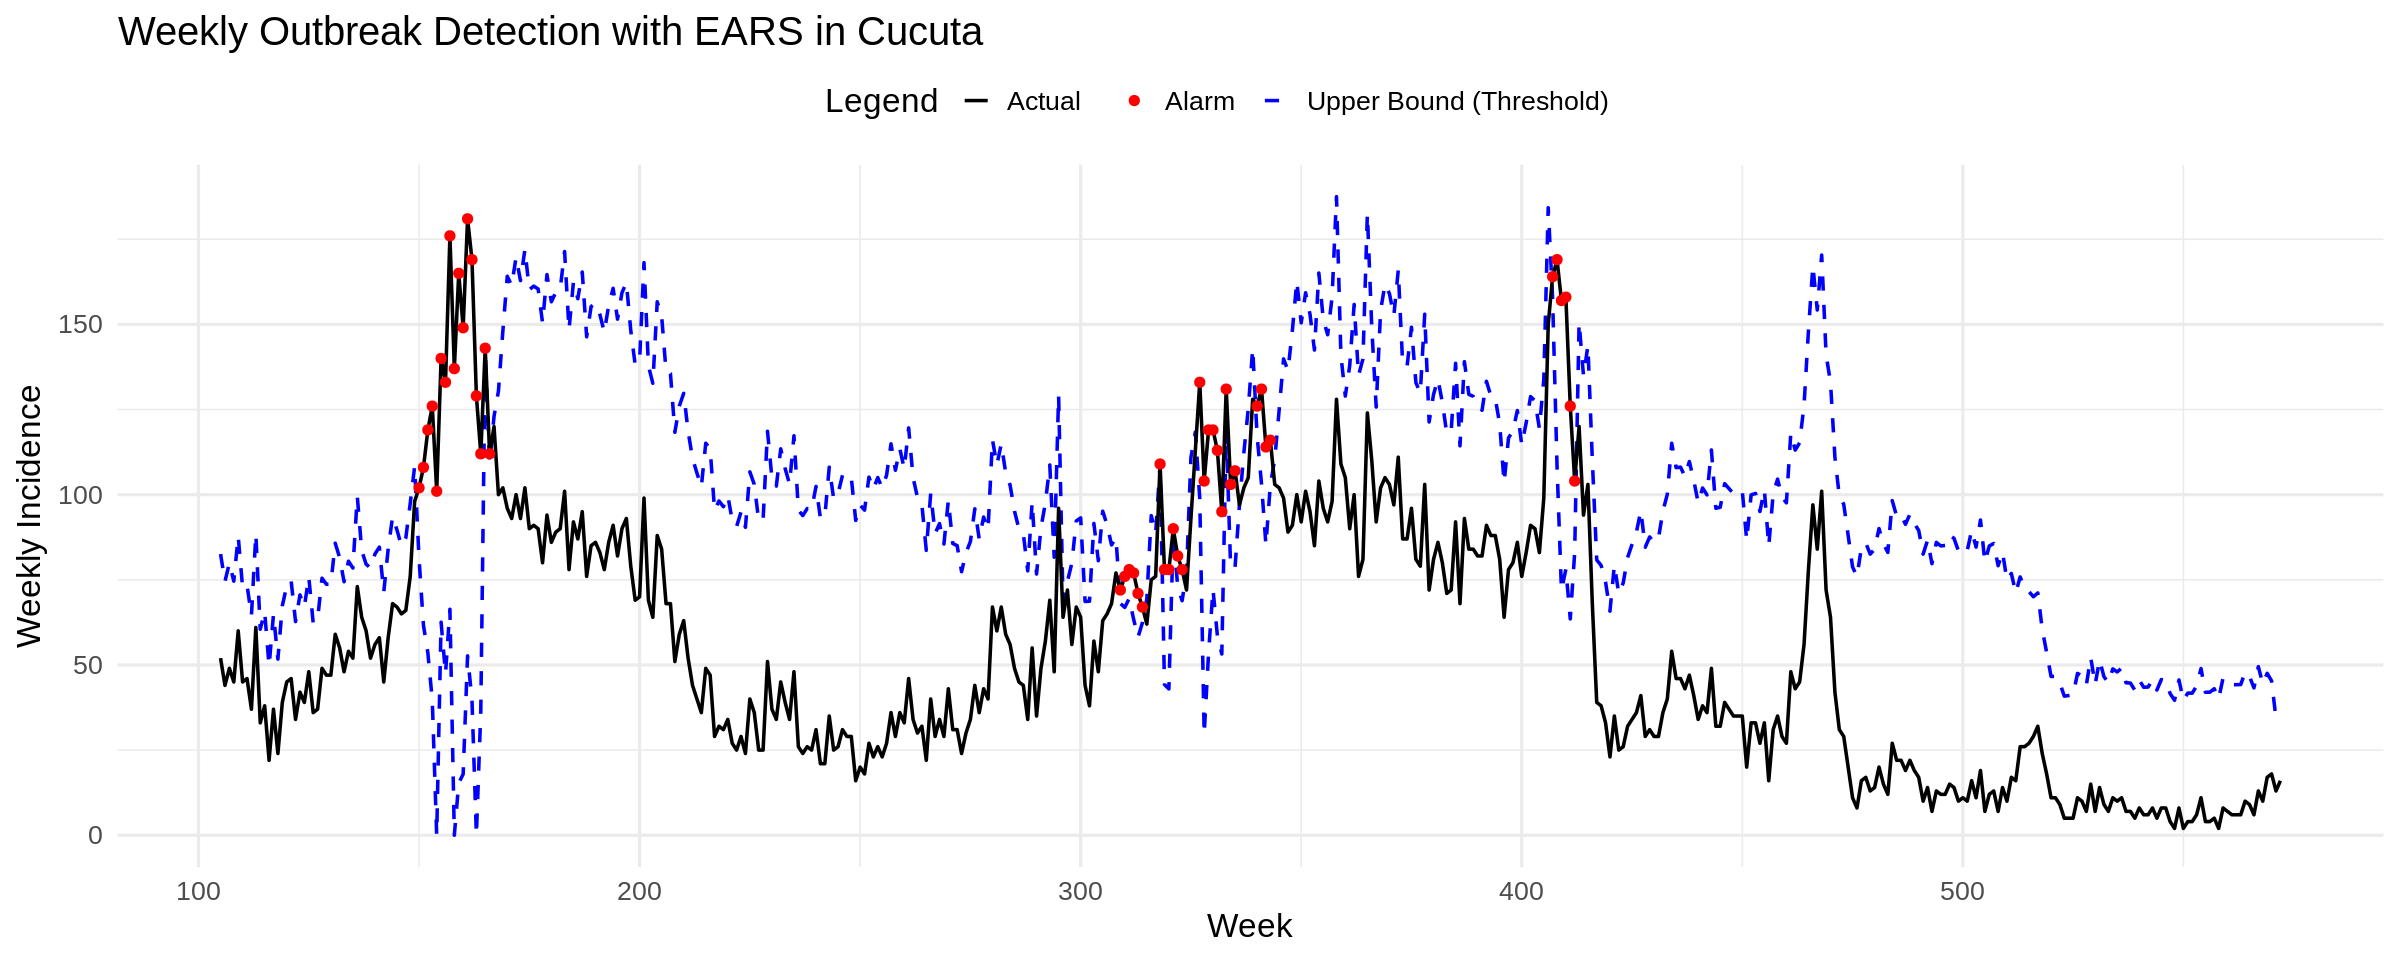

In [ ]:
plot_detector_forecast(global_result_cucuta, "EARS", "Cucuta")

### Plot Outbreak Bello + Moniquira

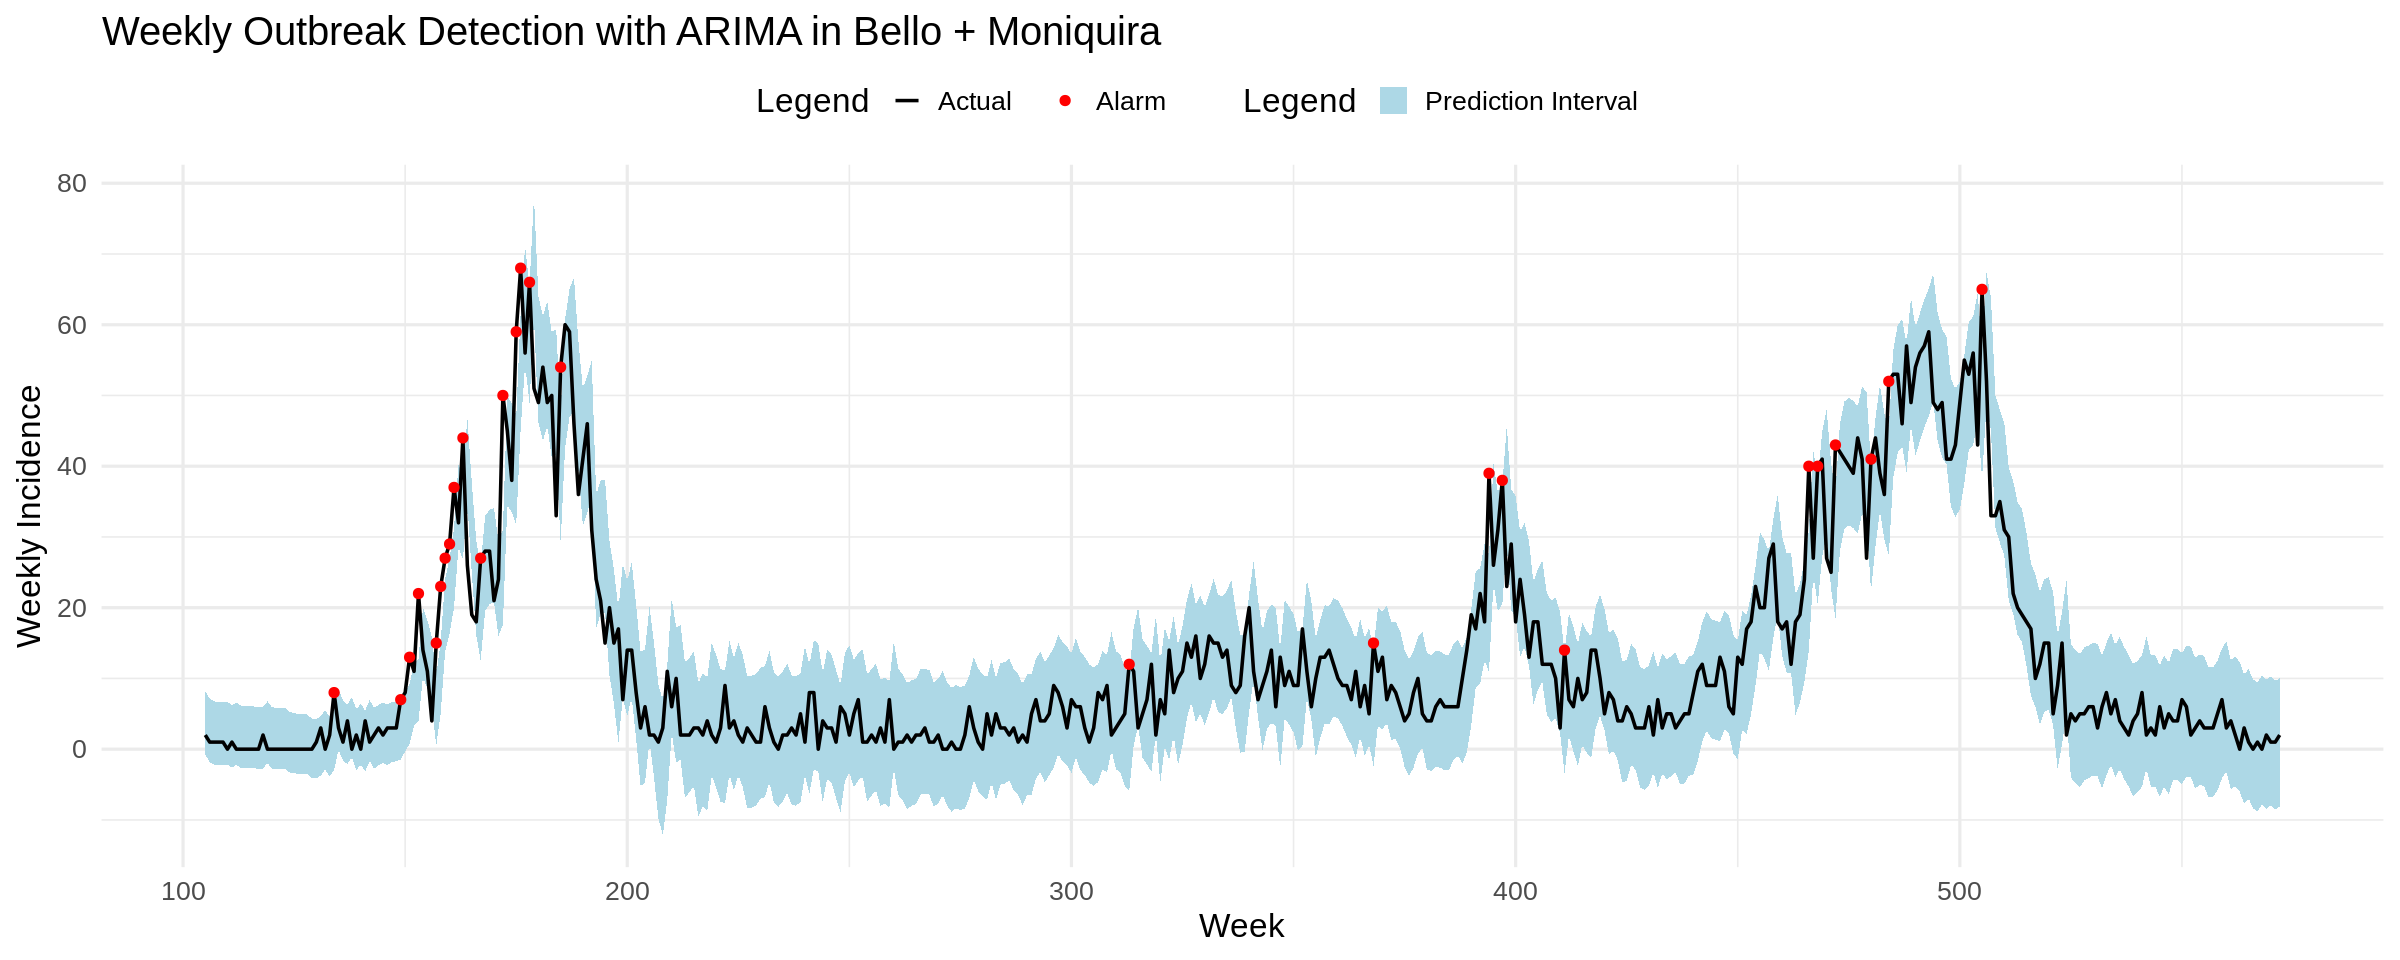

In [ ]:
plot_detector_forecast(global_result_bemon, "ARIMA", "Bello + Moniquira")

Warning message:
“No shared levels found between `names(values)` of the manual scale and the
data's fill values.”


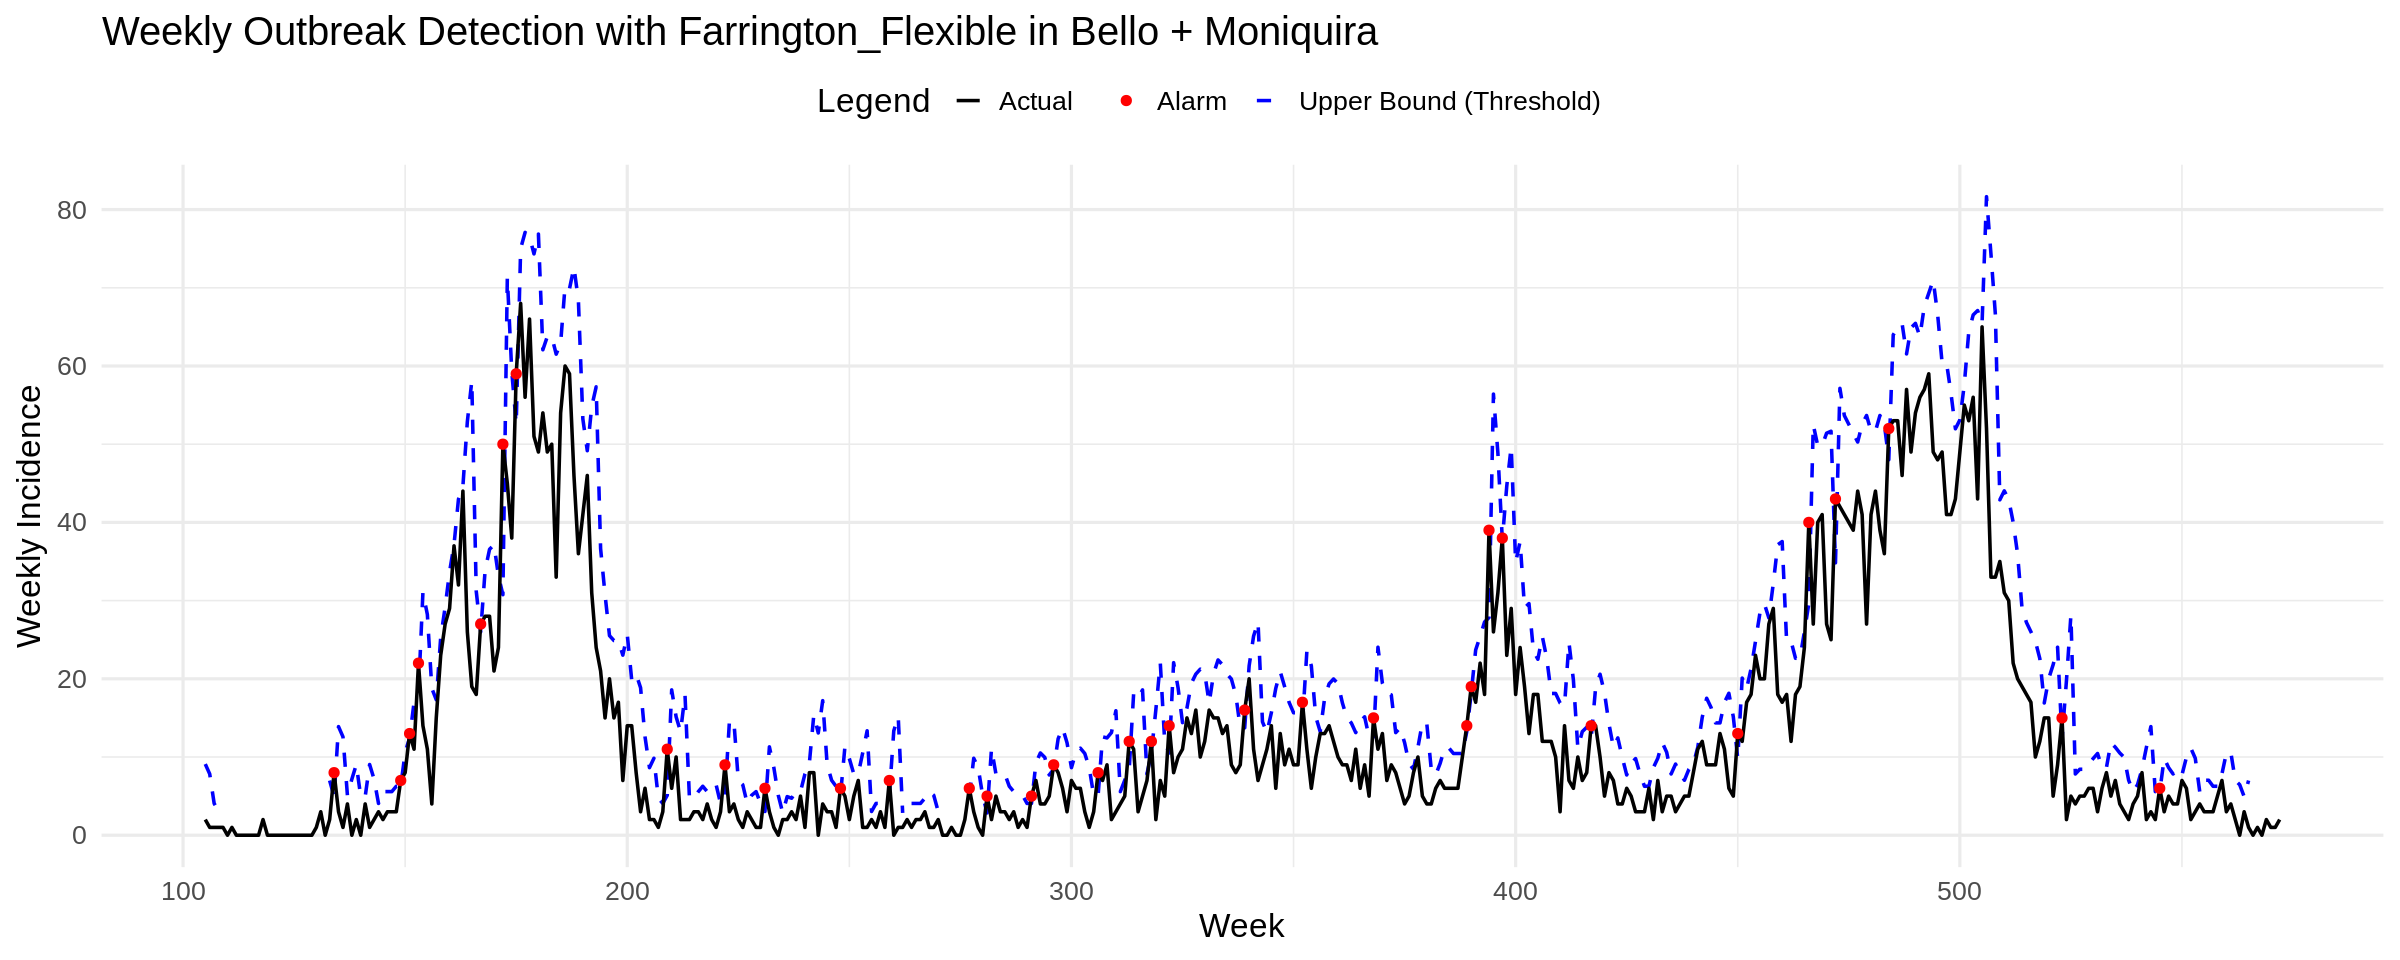

In [ ]:
plot_detector_forecast(global_result_bemon, "Farrington_Flexible", "Bello + Moniquira")

Warning message:
“No shared levels found between `names(values)` of the manual scale and the
data's fill values.”


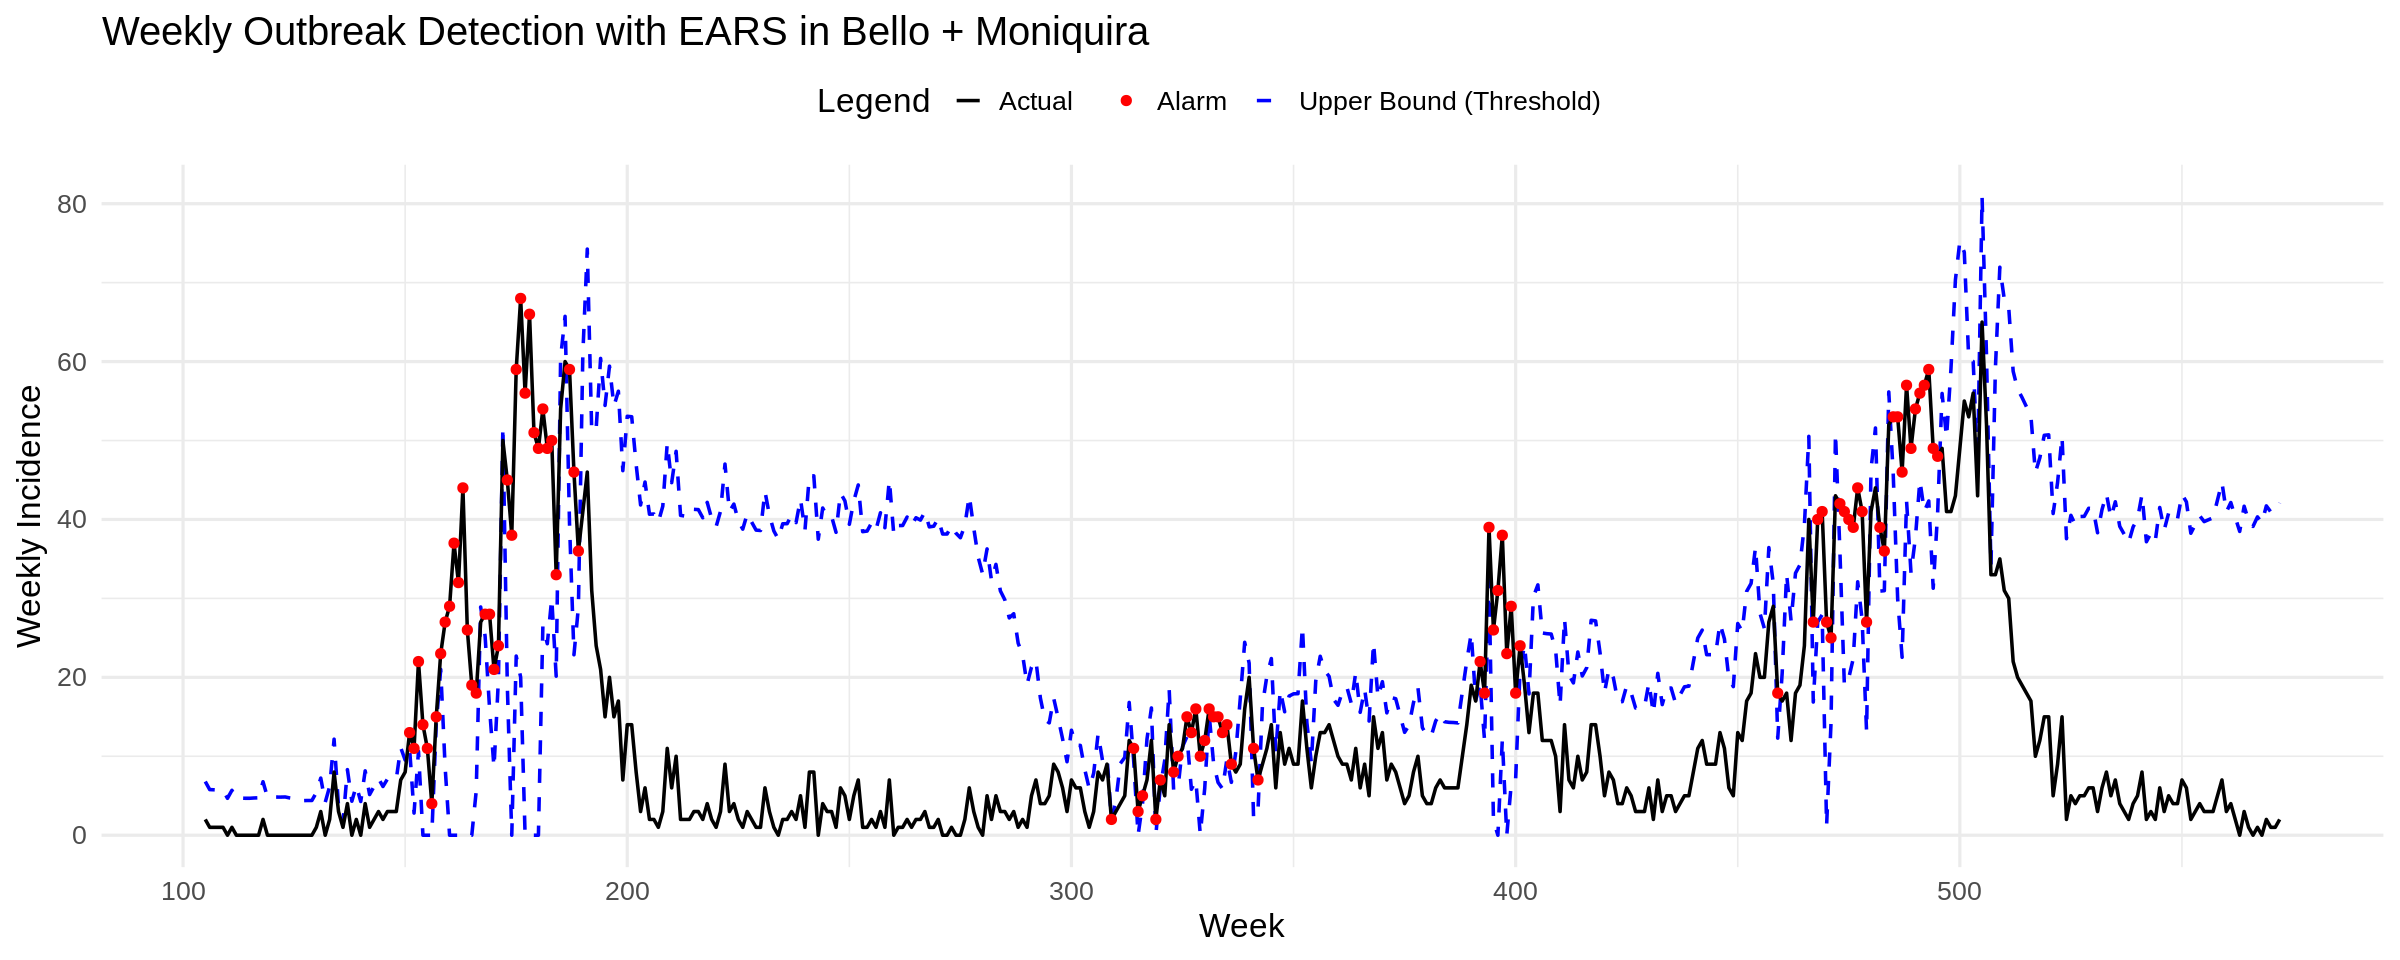

In [ ]:
plot_detector_forecast(global_result_bemon, "EARS", "Bello + Moniquira")

# Export to CSV to later processed into the evaluation framework

In [ ]:
library(googledrive)
drive_auth()  # Drive Authentication

The googledrive package is requesting access to your Google account.
Enter '1' to start a new auth process or select a pre-authorized account.
1: Send me to the browser for a new auth process.
2: nadillia.sahputra@isi.it


Selection: 2


In [ ]:
# Get the folder id (not sure why I can't just directly put the folder name to save the file)
mosquito_id <- drive_find(type = "folder", pattern = "Mosquito_Data") %>%
  filter(name == "Mosquito_Data") %>%
  pull(id)

In [ ]:
# Re-organize exported data
exp_cucuta <- inner_join(
  cucuta_dengue,
  global_result_cucuta$signals,
  by = "Week"
)

head(exp_cucuta, 2)
tail(exp_cucuta, 2)

Municipality,Year,Week_inY,Reported_Cases,Week,Farrington_Flexible,EARS,ARIMA
<chr>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
Cucuta,2009,1,52,105,0,0,0
Cucuta,2009,2,44,106,0,0,0


Municipality,Year,Week_inY,Reported_Cases,Week,Farrington_Flexible,EARS,ARIMA
<chr>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
Cucuta,2017,51,13,571,0,0,0
Cucuta,2017,52,16,572,0,0,0


In [ ]:
write.csv(exp_cucuta, "dengue_cucuta.csv", row.names = FALSE)
drive_upload("dengue_cucuta.csv", path = as_id(mosquito_id), overwrite = TRUE)

File trashed:

• dengue_cucuta.csv <id: 1FZ_avit_W5kgxX1Ly-PTy7QgICL2zcDK>

Local file:

• dengue_cucuta.csv

Uploaded into Drive file:

• dengue_cucuta.csv <id: 13iyPlgJAJNOh_0ckiObTVyubSLoCg5gs>

With MIME type:

• text/csv



In [ ]:
# Re-organize exported data
exp_bemon <- inner_join(
  bemon_dengue,
  global_result_bemon$signals,
  by = "Week"
)

write.csv(exp_bemon, "dengue_bemon.csv", row.names = FALSE)

head(exp_bemon, 2)
tail(exp_bemon, 2)

Municipality,Year,Week_inY,Reported_Cases,Week,Farrington_Flexible,EARS,ARIMA
<chr>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
Bello+Moniquira,2009,1,2,105,0,0,0
Bello+Moniquira,2009,2,1,106,0,0,0


Municipality,Year,Week_inY,Reported_Cases,Week,Farrington_Flexible,EARS,ARIMA
<chr>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
Bello+Moniquira,2017,51,1,571,0,0,0
Bello+Moniquira,2017,52,2,572,0,0,0


In [ ]:
write.csv(exp_bemon, "dengue_bemon.csv", row.names = FALSE)
drive_upload("dengue_bemon.csv", path = as_id(mosquito_id), overwrite = TRUE)

Local file:

• dengue_bemon.csv

Uploaded into Drive file:

• dengue_bemon.csv <id: 1lJYd4Z4PbpP2VflXhqJevO1or9N0QUZb>

With MIME type:

• text/csv

